## Import all the requiered libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
# Load the dataset
data = pd.read_excel('data/M2.xlsx')

# Split the data into features (X) and target (y)
X = data.drop(columns=['EC']).values
y = data['EC'].values.reshape(-1, 1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


KeyError: "['EC'] not found in axis"

In [12]:
X[:6]

array([[ 274.68   ,  695.85412,  194.108  , 2111.033  ,   35.305  ],
       [ 216.43   ,  440.69755,  129.725  , 1388.57   ,   23.656  ],
       [ 205.56   ,  473.9763 ,  122.522  , 1394.069  ,   15.576  ],
       [ 267.57   ,  600.802  ,  160.494  , 1796.989  ,   24.564  ],
       [ 209.31   ,  401.088  ,  102.076  , 1121.01   ,   17.483  ],
       [ 168.23   ,  836.5    ,  191.207  , 1493.9325 ,   35.394  ]])

In [13]:
# Convert the data into PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)


In [14]:
# Define the LSTM model
class LSTMRegressor(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMRegressor, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])  # Use only the last output
        return out

In [15]:
# Define model parameters
input_size = X.shape[1]
hidden_size = 128
num_layers = 2
output_size = 1

In [16]:
# Instantiate the model
model = LSTMRegressor(input_size, hidden_size, num_layers, output_size)

In [26]:
# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.008)

In [27]:
# Training loop
num_epochs = 50000
train_losses = []
val_losses = []
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train.unsqueeze(1))  # Add sequence length dimension
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test.unsqueeze(1))  # Add sequence length dimension
        val_loss = criterion(val_outputs, y_test)
        val_losses.append(val_loss.item())

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')




Epoch [1/50000], Train Loss: 27737640.0000, Val Loss: 20690876.0000
Epoch [2/50000], Train Loss: 27730658.0000, Val Loss: 20684650.0000
Epoch [3/50000], Train Loss: 27723674.0000, Val Loss: 20678424.0000
Epoch [4/50000], Train Loss: 27716694.0000, Val Loss: 20672200.0000
Epoch [5/50000], Train Loss: 27709714.0000, Val Loss: 20665976.0000
Epoch [6/50000], Train Loss: 27702740.0000, Val Loss: 20659752.0000
Epoch [7/50000], Train Loss: 27695758.0000, Val Loss: 20653534.0000


Epoch [8/50000], Train Loss: 27688782.0000, Val Loss: 20647316.0000
Epoch [9/50000], Train Loss: 27681808.0000, Val Loss: 20641094.0000
Epoch [10/50000], Train Loss: 27674836.0000, Val Loss: 20634876.0000
Epoch [11/50000], Train Loss: 27667860.0000, Val Loss: 20628664.0000
Epoch [12/50000], Train Loss: 27660892.0000, Val Loss: 20622450.0000
Epoch [13/50000], Train Loss: 27653922.0000, Val Loss: 20616238.0000
Epoch [14/50000], Train Loss: 27646956.0000, Val Loss: 20610026.0000
Epoch [15/50000], Train Loss: 27639992.0000, Val Loss: 20603814.0000
Epoch [16/50000], Train Loss: 27633024.0000, Val Loss: 20597608.0000
Epoch [17/50000], Train Loss: 27626062.0000, Val Loss: 20591402.0000
Epoch [18/50000], Train Loss: 27619096.0000, Val Loss: 20585198.0000
Epoch [19/50000], Train Loss: 27612140.0000, Val Loss: 20578996.0000
Epoch [20/50000], Train Loss: 27605180.0000, Val Loss: 20572792.0000
Epoch [21/50000], Train Loss: 27598226.0000, Val Loss: 20566592.0000
Epoch [22/50000], Train Loss: 275912

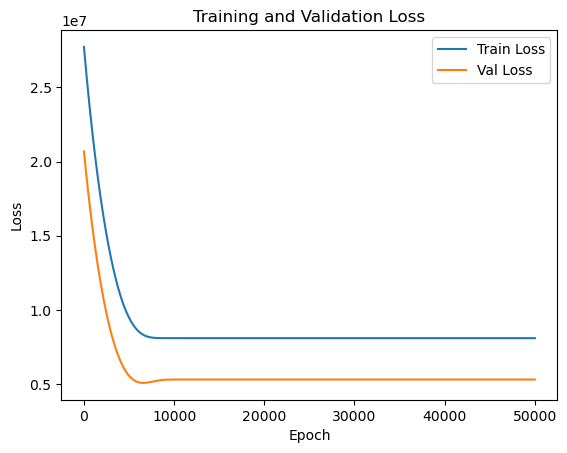

In [28]:
# Plot training and validation loss
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [29]:
# Save ground truth and predictions to an Excel file
with torch.no_grad():
    predictions = model(X_test.unsqueeze(1)).numpy()
    df = pd.DataFrame({'GroundTruth': y_test.squeeze().numpy(),
                       'Prediction': predictions.squeeze()})
    df.to_excel('results/LSTM.xlsx', index=True)

In [30]:
# Predict random data from the validation set
random_index = np.random.randint(len(X_test))
random_data = X_test[random_index].reshape(1, 1, -1)  # Reshape to match model input dimensions
model.eval()
with torch.no_grad():
    prediction = model(random_data)
    print("Predicted value:", prediction.item())
    print("Actual value:", y_test[random_index].item())

Predicted value: 6014.16796875
Actual value: 4430.0


In [31]:
# Save the model state dictionary
torch.save(model.state_dict(), 'models/StateLSTM.pth')
# Save the entire model
torch.save(model, 'models/LSTM.pth')